# Projeto Airbnb Rio - Ferramenta de Previsão de Preço de Imóvel para pessoas comuns 

### Contexto

No Airbnb, qualquer pessoa que tenha um quarto ou um imóvel de qualquer tipo (apartamento, casa, chalé, pousada, etc.) pode ofertar o seu imóvel para ser alugado por diária.

Você cria o seu perfil de host (pessoa que disponibiliza um imóvel para aluguel por diária) e cria o anúncio do seu imóvel.

### Nosso objetivo

Construir um modelo de previsão de preço que permita uma pessoa comum que possui um imóvel possa saber quanto deve cobrar pela diária do seu imóvel.

Ou ainda, para o locador comum, dado o imóvel que ele está buscando, ajudar a saber se aquele imóvel está com preço atrativo (abaixo da média para imóveis com as mesmas características) ou não.

### O que temos disponível, inspirações e créditos

As bases de dados foram retiradas do site kaggle: https://www.kaggle.com/allanbruno/airbnb-rio-de-janeiro

- As bases de dados são os preços dos imóveis obtidos e suas respectivas características em cada mês.
- Os preços são dados em reais (R$)
- Temos bases de abril de 2018 a maio de 2020, com exceção de junho de 2018 que não possui base de dados

### Importar Bibliotecas e Bases de Dados

In [15]:
import pandas as pd
import pathlib
from tqdm import tqdm
import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime

### Consolidar Base de Dados

In [16]:
#Dicionário auxiliar para adicionar o nome do mês ao dataframe
meses = {'jan': 1, 'fev': 2, 'mar': 3, 'abr': 4, 'mai': 5, 'jun': 6, 'jul': 7, 'ago': 8, 'set': 9, 'out': 10, 'nov': 11, 'dez': 12}

caminho = pathlib.Path('dataset')
    
base_airbnb = pd.DataFrame()

load_bar = tqdm(total=25, position=0, leave=True) #criando uma barra de carregamento
    
for arquivo in caminho.iterdir():

    mes = meses[arquivo.name[:3]] #Tratando nome dos aquivos para colocar o numero dos meses no Dataframe 
    ano = int(arquivo.name[-8:-4]) #Tratando nome dos aquivos para colocar o ano no dataframe

    df = pd.read_csv(caminho / arquivo.name, low_memory=False)
    df['mes'] = mes 
    df['ano'] = ano

    base_airbnb = pd.concat([base_airbnb, df])

    load_bar.update()

display(base_airbnb)

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [02:55<00:00, 14.11s/it]

id                            listing_url       scrape_id  \
0         14063     https://www.airbnb.com/rooms/14063  20180414160018   
1         17878     https://www.airbnb.com/rooms/17878  20180414160018   
2         24480     https://www.airbnb.com/rooms/24480  20180414160018   
3         25026     https://www.airbnb.com/rooms/25026  20180414160018   
4         31560     https://www.airbnb.com/rooms/31560  20180414160018   
...         ...                                    ...             ...   
34324  38844730  https://www.airbnb.com/rooms/38844730  20190923212307   
34325  38846408  https://www.airbnb.com/rooms/38846408  20190923212307   
34326  38846703  https://www.airbnb.com/rooms/38846703  20190923212307   
34327  38847050  https://www.airbnb.com/rooms/38847050  20190923212307   
34328  38847655  https://www.airbnb.com/rooms/38847655  20190923212307   

      last_scraped                                          name  \
0       2018-04-14                          Living in a Postcard   
1       2018-04-14             Very Nice 2Br - Copacabana - WiFi   
2       2018-04-14              Nice and cozy near Ipanema Beach   
3       2018-04-14     Beautiful Modern Decorated Studio in Copa   
4       2018-04-14              NICE & COZY 1BDR - IPANEMA BEACH   
...            ...                                           ...   
34324   2019-09-24             TRANSAMERICA BARRA DA TIJUCA R IV   
34325   2019-09-24                      Alugo para o Rock in Rio   
34326   2019-09-24  Apt COMPLETO em COPACABANA c/TOTAL SEGURANÇA   
34327   2019-09-24                     Cobertura Cinematografica   
34328   2019-09-24     Quarto em cobertura em frente à praia III   

                                                 summary  \
0      Besides the most iconic's view, our apartment ...   
1      Please note that special rates apply for New Y...   
2      My studio is located in the best  of Ipanema. ...   
3      Our apartment is a little gem, everyone loves ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...   
34325  Confortável apartamento, 2 quartos , sendo 1 s...   
34326  Apartamento quarto e sala COMPLETO para curtas...   
34327                               Cobertura alto nivel   
34328  Quarto em cobertura quadriplex com vista lindí...   

                                                   space  \
0                                                    NaN   
1      - large balcony which looks out on pedestrian ...   
2      The studio is located at Vinicius de Moraes St...   
3      This newly renovated studio (last renovations ...   
4      This nice and clean 1 bedroom apartment is loc...   
...                                                  ...   
34324                                                NaN   
34325  O apartamento estará com mobília completa disp...   
34326  Espaço ideal para até 5 pessoas. Cama de casal...   
34327                                                NaN   
34328                                                NaN   

                                             description experiences_offered  \
0      Besides the most iconic's view, our apartment ...                none   
1      Please note that special rates apply for New Y...                none   
2      My studio is located in the best  of Ipanema. ...                none   
3      Our apartment is a little gem, everyone loves ...                none   
4      This nice and clean 1 bedroom apartment is loc...                none   
...                                                  ...                 ...   
34324  Em estilo contemporâneo, o Transamerica Prime ...                none   
34325  Confortável apartamento, 2 quartos , sendo 1 s...                none   
34326  Apartamento quarto e sala COMPLETO para curtas...                none   
34327                               Cobertura alto nivel         

### Verificando que tipo de colunas excluir
- Como existem muitas colunas, o modelo pode ficar lento.
- Existem varias colunas que não são necessárias para o modelo de previsão, por isso vamos excluir algumas delas.
- Tipos de colunas que serão excluidas:
    1. IDs, links e informações irrelavantes
    2. Colunas com informações repetidas    
    3. Colunas com texto livre
    4. Colunas em que todos os valores estão iguais


- Para isso, vamos criar um arquivo em excel com os 1000 primeiros registros.

In [17]:
#Criando base de dados em csv
base_airbnb.head(1000).to_csv('primeiros_registros1.csv', sep=';')

In [18]:
#Esta é a lista de colunas totais antes de verificarmos quais delas seriam úteis ou não
for coluna in base_airbnb.columns:
    print(coluna)

id
listing_url
scrape_id
last_scraped
name
summary
space
description
experiences_offered
neighborhood_overview
notes
transit
access
interaction
house_rules
thumbnail_url
medium_url
picture_url
xl_picture_url
host_id
host_url
host_name
host_since
host_location
host_about
host_response_time
host_response_rate
host_acceptance_rate
host_is_superhost
host_thumbnail_url
host_picture_url
host_neighbourhood
host_listings_count
host_total_listings_count
host_verifications
host_has_profile_pic
host_identity_verified
street
neighbourhood
neighbourhood_cleansed
neighbourhood_group_cleansed
city
state
zipcode
market
smart_location
country_code
country
latitude
longitude
is_location_exact
property_type
room_type
accommodates
bathrooms
bedrooms
beds
bed_type
amenities
square_feet
price
weekly_price
monthly_price
security_deposit
cleaning_fee
guests_included
extra_people
minimum_nights
maximum_nights
calendar_updated
has_availability
availability_30
availability_60
availability_90
availability_365
cal

### Temos muitas colunas, vamos identificar quais podemos escluir 

In [19]:
print(base_airbnb['experiences_offered'].value_counts())

none    902210
Name: experiences_offered, dtype: int64


In [20]:
print((base_airbnb['host_listings_count']==base_airbnb['host_total_listings_count']).value_counts())

True     901750
False       460
dtype: int64


In [21]:
#Coluna 'square_feet' tem quase todos os valores nulos
print('Soma de colunas nulas: {}'.format(base_airbnb['square_feet'].isnull().sum()))

Soma de colunas nulas: 888162


### Depois da análise quantitativa de colunas levando em conta os critérios acima, ficamos com as seguintes colunas:

In [23]:
#df_novo = pd.read_csv('primeiros_registros.csv', sep=";", encoding='cp1252')
#colunas = df_novo.columns
#print(list(colunas))
colunas = ['host_response_time', 'host_response_rate', 'host_is_superhost', 'host_listings_count', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'price', 'security_deposit', 'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights', 'maximum_nights', 'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable', 'is_business_travel_ready', 'cancellation_policy', 'mes', 'ano']

#Usando o método loc para sustituir as antigas colunas do dataframe palas novas

base_airbnb = base_airbnb.loc[:, colunas]
display(base_airbnb)

host_response_time host_response_rate host_is_superhost  \
0                     NaN                NaN                 f   
1          within an hour               100%                 t   
2          within an hour               100%                 f   
3          within an hour               100%                 f   
4          within an hour               100%                 t   
...                   ...                ...               ...   
34324      within an hour                93%                 f   
34325                 NaN                NaN                 f   
34326  within a few hours                74%                 f   
34327                 NaN                NaN                 f   
34328  a few days or more                38%                 f   

       host_listings_count   latitude  longitude property_type  \
0                      1.0 -22.946854 -43.182737     Apartment   
1                      2.0 -22.965919 -43.178962   Condominium   
2                      1.0 -22.985698 -43.201935     Apartment   
3                      3.0 -22.977117 -43.190454     Apartment   
4                      1.0 -22.983024 -43.214270     Apartment   
...                    ...        ...        ...           ...   
34324                  0.0 -23.003180 -43.342840     Apartment   
34325                  0.0 -22.966640 -43.393450     Apartment   
34326                 32.0 -22.962080 -43.175520     Apartment   
34327                  0.0 -23.003400 -43.341820     Apartment   
34328                  5.0 -23.010560 -43.363350     Apartment   

             room_type  accommodates  bathrooms  ...  \
0      Entire home/apt             4        1.0  ...   
1      Entire home/apt             5        1.0  ...   
2      Entire home/apt             2        1.0  ...   
3      Entire home/apt             3        1.0  ...   
4      Entire home/apt             3        1.0  ...   
...                ...           ...        ...  ...   
34324  Entire home/apt             4        1.0  ...   
34325  Entire home/apt             4        2.0  ...   
34326  Entire home/apt             5        1.0  ...   
34327  Entire home/apt             4        1.0  ...   
34328     Private room             2        0.0  ...   

       review_scores_cleanliness  review_scores_checkin  \
0                            9.0                    9.0   
1                            9.0                   10.0   
2                           10.0                   10.0   
3                           10.0                   10.0   
4                           10.0                   10.0   
...                          ...                    ...   
34324                        NaN                    NaN   
34325                        NaN                    NaN   
34326                        NaN                    NaN   
34327                        NaN                    NaN   
34328                        NaN                    NaN   

      review_scores_communication review_scores_location review_scores_value  \
0                             9.0                    9.0                 9.0   
1                            10.0                    9.0                 9.0   
2                            10.0                   10.0                 9.0   
3                            10.0                   10.0                 9.0   
4                            10.0                   10.0                 9.0   
...                           ...                    ...                 ...   
34324                         NaN                    NaN                 NaN   
34325                         NaN                    NaN                 NaN   
34326                         NaN                    NaN                 NaN   
34327                         NaN                    NaN                 NaN   
34328                         NaN                    NaN                 NaN   

      instant_bookable is_business_travel_ready          cancellation_policy  

### Tratar Valores Faltando
- Existem muitos dados faltando nas colunas
- As colunas que tiveram mais de 300000 dados faltando, foram excluidas.

In [24]:
print('Antes:\n')
print(base_airbnb.isnull().sum())

#Percorrendo a base de dados para excluir valores nulos maiores ou iguais a 300000
for coluna in base_airbnb:
    if base_airbnb[coluna].isnull().sum() > 300000:
        base_airbnb = base_airbnb.drop(coluna, axis=1)

print('\nDepois:\n')
print(base_airbnb.isnull().sum())

Antes:

host_response_time             401843
host_response_rate             401846
host_is_superhost                 460
host_listings_count               460
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                        1724
bedrooms                          850
beds                             2502
bed_type                            0
amenities                           0
price                               0
security_deposit               421280
cleaning_fee                   313506
guests_included                     0
extra_people                        0
minimum_nights                      0
maximum_nights                      0
number_of_reviews                   0
review_scores_rating           448016
review_scores_accuracy         448586
review_scores_cleanliness      448413
review_scores_checkin          448650
revi

In [25]:
#excluindo linhas em que os valores nulos estão vazios
base_airbnb = base_airbnb.dropna()

print(base_airbnb.shape)
print(base_airbnb.isnull().sum())

(897709, 23)
host_is_superhost           0
host_listings_count         0
latitude                    0
longitude                   0
property_type               0
room_type                   0
accommodates                0
bathrooms                   0
bedrooms                    0
beds                        0
bed_type                    0
amenities                   0
price                       0
guests_included             0
extra_people                0
minimum_nights              0
maximum_nights              0
number_of_reviews           0
instant_bookable            0
is_business_travel_ready    0
cancellation_policy         0
mes                         0
ano                         0
dtype: int64


### Verificar Tipos de Dados em cada coluna

In [26]:
print(base_airbnb.dtypes)
print('-'*60)
print(base_airbnb.iloc[0])

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                        object
guests_included               int64
extra_people                 object
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
dtype: object
------------------------------------------------------------
host_is_superhost                                                           f
host_listings_count

- As colunas (Preço) e (Extra People) estão sendo reconhecidas como objetos ao invés de float.

In [27]:
#price
base_airbnb['price'] = base_airbnb['price'].str.replace('$', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].str.replace(',', '', regex=False)
base_airbnb['price'] = base_airbnb['price'].astype(np.float32, copy=False)
#extra people
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace('$', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].str.replace(',', '', regex=False)
base_airbnb['extra_people'] = base_airbnb['extra_people'].astype(np.float32, copy=False)

print(base_airbnb.dtypes)

host_is_superhost            object
host_listings_count         float64
latitude                    float64
longitude                   float64
property_type                object
room_type                    object
accommodates                  int64
bathrooms                   float64
bedrooms                    float64
beds                        float64
bed_type                     object
amenities                    object
price                       float32
guests_included               int64
extra_people                float32
minimum_nights                int64
maximum_nights                int64
number_of_reviews             int64
instant_bookable             object
is_business_travel_ready     object
cancellation_policy          object
mes                           int64
ano                           int64
dtype: object


### Análise Exploratória e Tratar Outliers

- Vamos basicamente olhar feature por feature para:
    1. Ver a correlação entre as features e decidir se manteremos todas as features que temos.
    2. Excluir outliers (usaremos como regra, valores abaixo de Q1 - 1.5xAmplitude e valores acima de Q3 + 1.5x Amplitude). Amplitude = Q3 - Q1
    3. Confirmar se todas as features que temos fazem realmente sentido para o nosso modelo ou se alguma delas não vai nos ajudar e se devemos excluir

<AxesSubplot:>

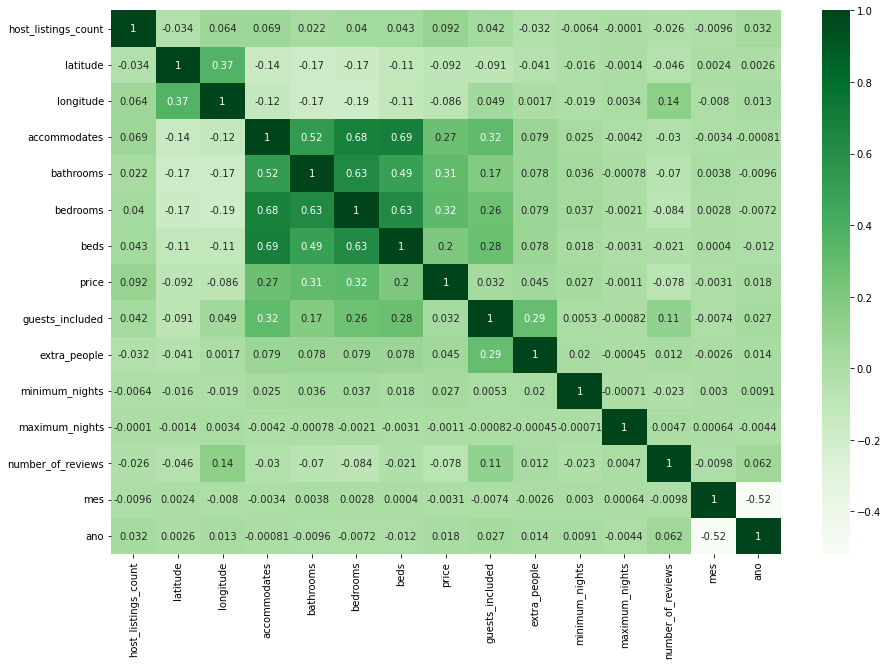

In [28]:
#Usando a ideia de quartis da (estatística) para tratar os valores muito altos ou muito baixos
#Limite superior = Q1 - 1,5 x amplitude
#limite inferior = Q3 + 1,5 x amplitude

plt.figure(figsize=(15, 10))
sns.heatmap(base_airbnb.corr(), annot=True, cmap='Greens')

### Definição de funções para análise de outliers
- Vamos definir algumas funções para análise de outliers 

In [29]:
#função do calculo do limite superior e inferior
def limites(coluna):
    q1 = coluna.quantile(0.25) #o método quantile calcula o quartil desejado
    q3 = coluna.quantile(0.75)
    amplitude = q3 - q1
    return q1 - 1.5 * amplitude, q3 + 1.5 * amplitude

#criando função de excluir outliers
def excluir_outliers(df, nome_coluna):
    qtd_linhas = df.shape[0]
    lim_inf, lim_sup = limites(df[nome_coluna])
    df = df.loc[(df[nome_coluna] >= lim_inf) & (df[nome_coluna] <= lim_sup),:]
    linhas_removidas = qtd_linhas - df.shape[0]
    return df, linhas_removidas

In [30]:
print(limites(base_airbnb['price']))
print('\n\n')

print(base_airbnb['price'].describe())

(-524.0, 1276.0)



count    897709.000000
mean        648.062195
std        1705.104980
min           0.000000
25%         151.000000
50%         297.000000
75%         601.000000
max      138288.000000
Name: price, dtype: float64


In [31]:
def diagrama_caixa(coluna):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(15, 5) #setando um valor para o tamanho do gráfico (de forma diferente)
    sns.boxplot(x=coluna, ax=ax1) #eixo do X vai ser formado pela variavel coluna
    ax2.set_xlim(limites(coluna)) #setando dado na segunda imagem chamando a func. limites que retorna (limite1, limite2)
    sns.boxplot(x=coluna, ax=ax2)
    
def histograma(coluna):
    plt.figure(figsize=(15, 5))
    sns.histplot(coluna, bins=50, kde=True)
    
#função de gráfico de barras
def grafico_barra(coluna):
    plt.figure(figsize=(15,5))
    ax = sns.barplot(x=coluna.value_counts().index, y=coluna.value_counts())
    ax.set_xlim(limites(coluna))
        

### Price

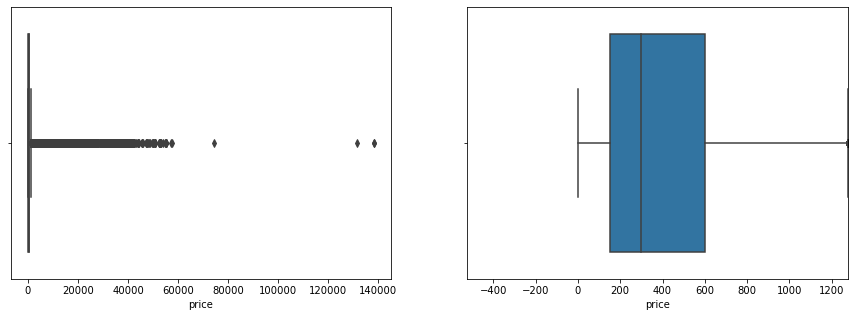

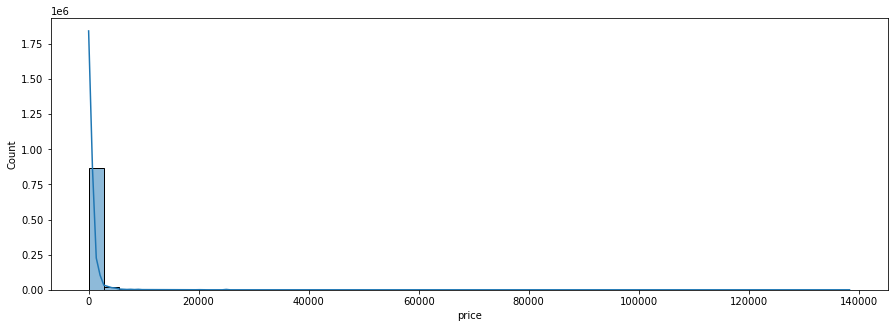

In [32]:
diagrama_caixa(base_airbnb['price'])
histograma(base_airbnb['price'])

- Como estamos contruindo um modelo par imóveis comuns, os valores acima do limite superior são de apartamentos de altíssimo luxo. Não sendo esse o nosso objetivo, vamos excluir esses outliers 

In [33]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'price')
print('{} linhas removidas'.format(linhas_removidas))

87282 linhas removidas


(810427, 23)


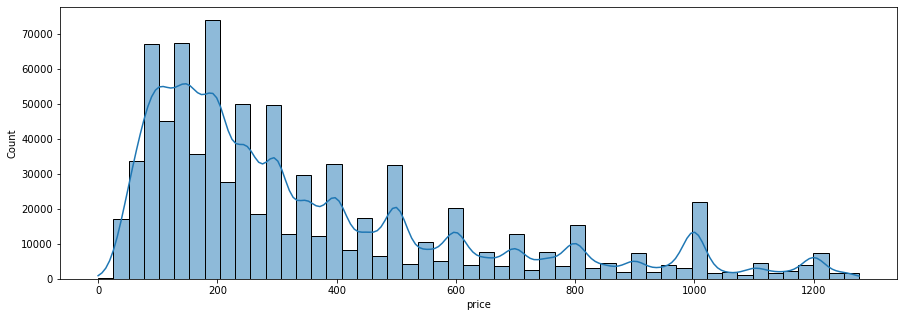

In [34]:
histograma(base_airbnb['price'])
print(base_airbnb.shape)

### Extra_people

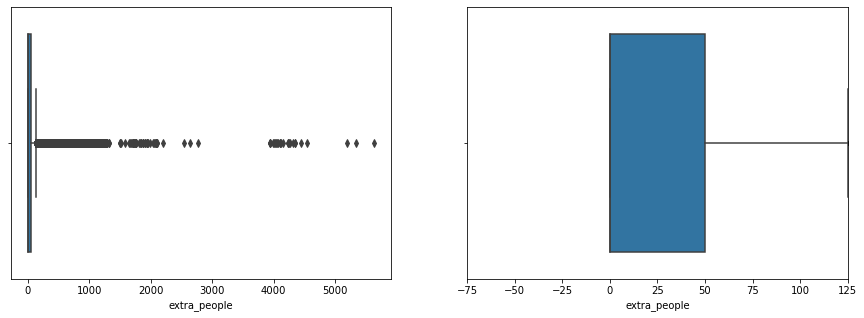

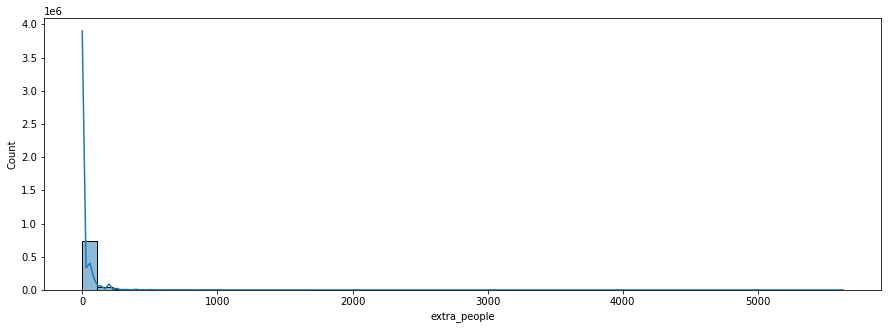

In [35]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])

In [36]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'extra_people')
print('{} linhas removidas'.format(linhas_removidas))

59194 linhas removidas


(751233, 23)


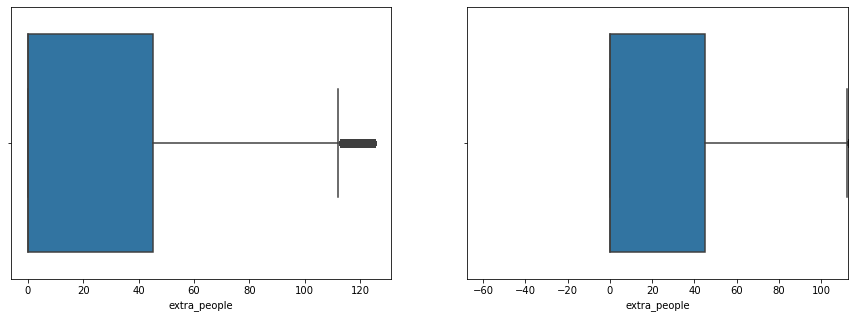

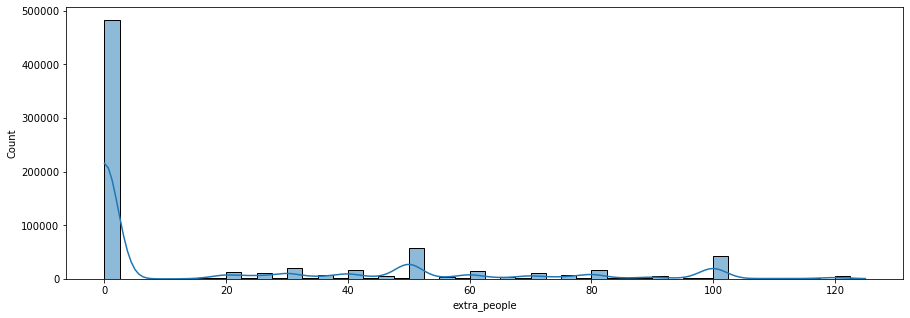

In [37]:
diagrama_caixa(base_airbnb['extra_people'])
histograma(base_airbnb['extra_people'])
print(base_airbnb.shape)

### host_listings_count

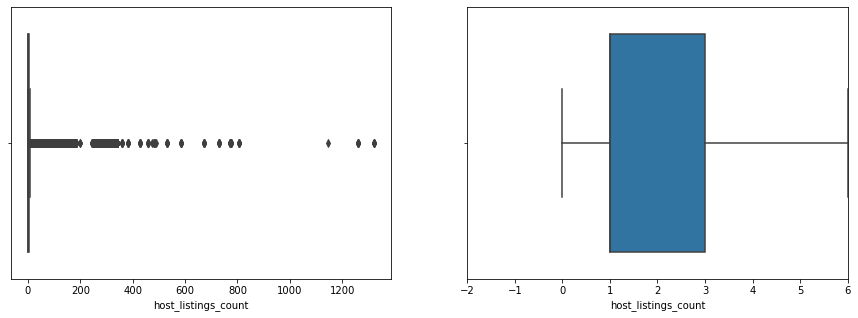

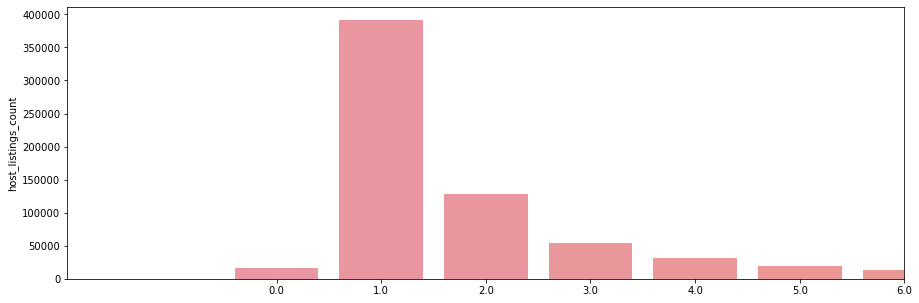

In [38]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

- Podemos excluir outliers porque hosts com mais de 6 imoveis não estão nos requisitos do nosso projetos, pois pessoas com essa quantidade de imóveis geralmente são imobiliarias

In [39]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'host_listings_count')
print('{} linhas removidas'.format(linhas_removidas))

97723 linhas removidas


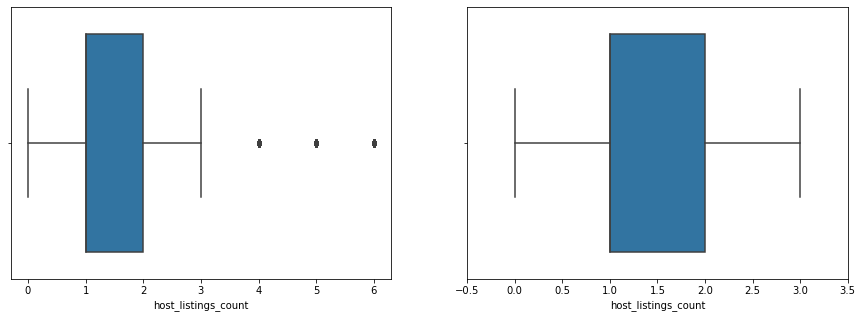

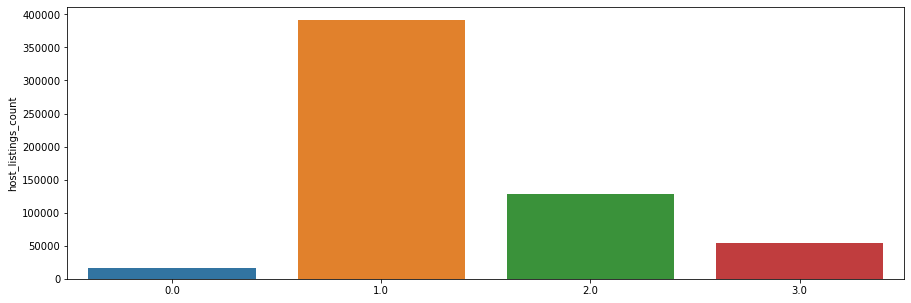

In [40]:
diagrama_caixa(base_airbnb['host_listings_count'])
grafico_barra(base_airbnb['host_listings_count'])

### accommodates

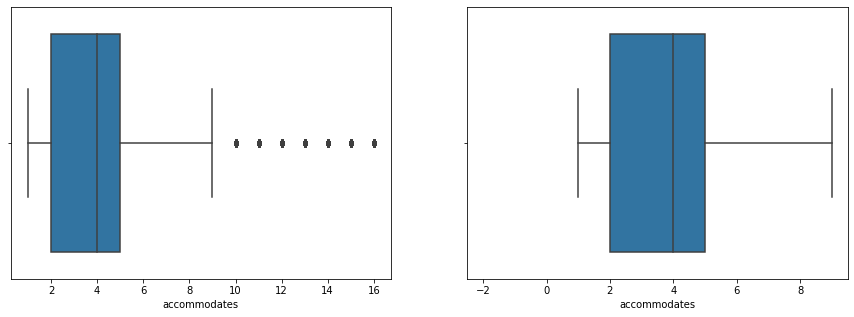

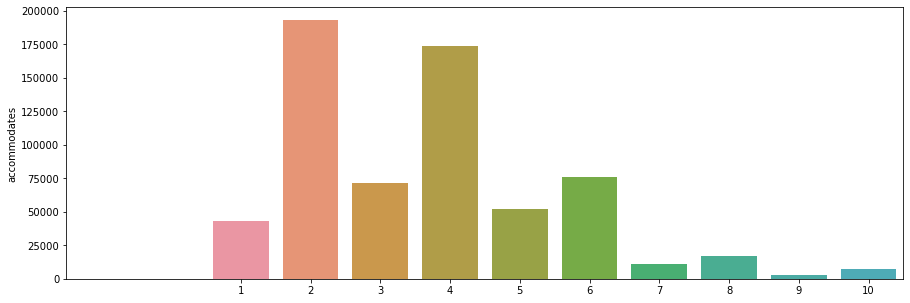

In [41]:
diagrama_caixa(base_airbnb['accommodates'])
grafico_barra(base_airbnb['accommodates'])

In [42]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'accommodates')
print('{} linhas removidas'.format(linhas_removidas))

13146 linhas removidas


### bathrooms

<AxesSubplot:ylabel='bathrooms'>

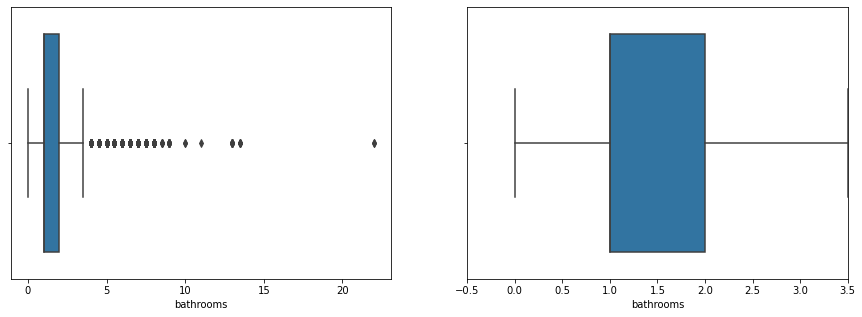

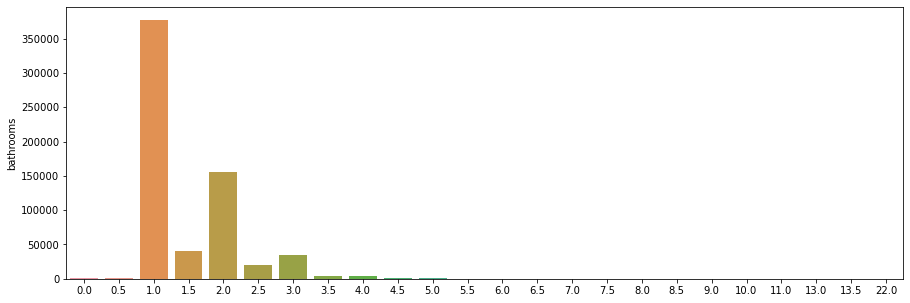

In [44]:
diagrama_caixa(base_airbnb['bathrooms'])
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['bathrooms'].value_counts().index, y=base_airbnb['bathrooms'].value_counts())

In [45]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bathrooms')
print('{} linhas removidas'.format(linhas_removidas))

6894 linhas removidas


### bedrooms

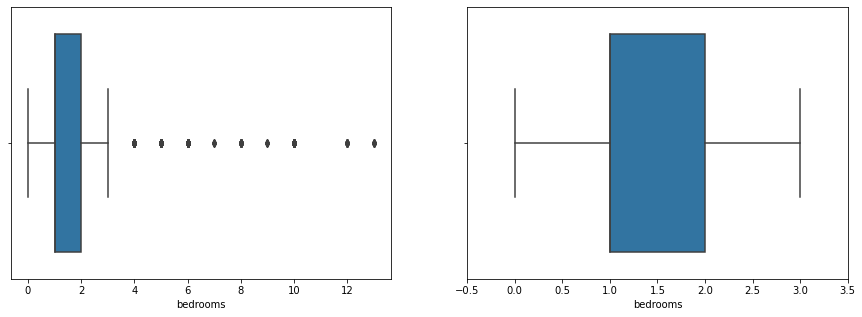

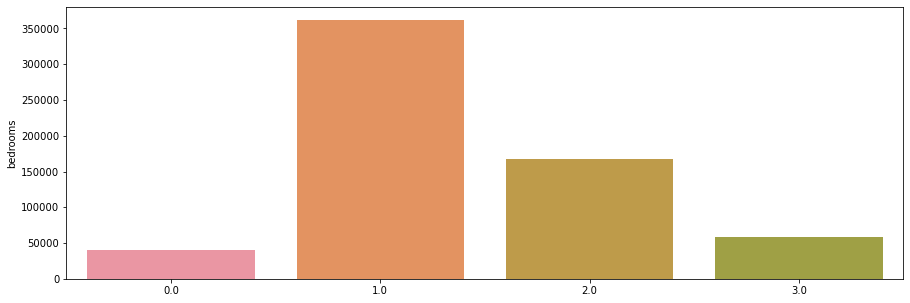

In [46]:
diagrama_caixa(base_airbnb['bedrooms'])
grafico_barra(base_airbnb['bedrooms'])

In [47]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'bedrooms')
print('{} linhas removidas'.format(linhas_removidas))

5482 linhas removidas


### beds

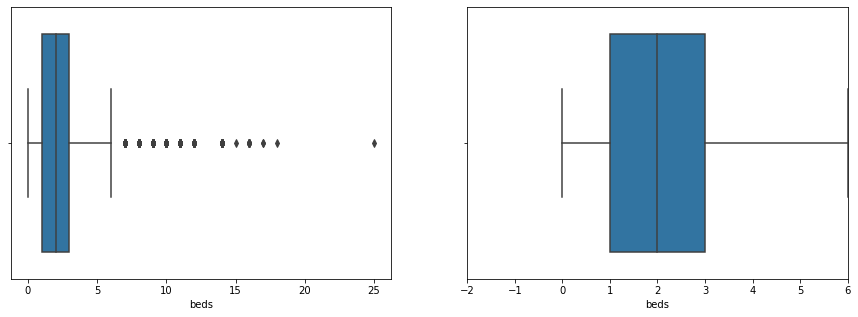

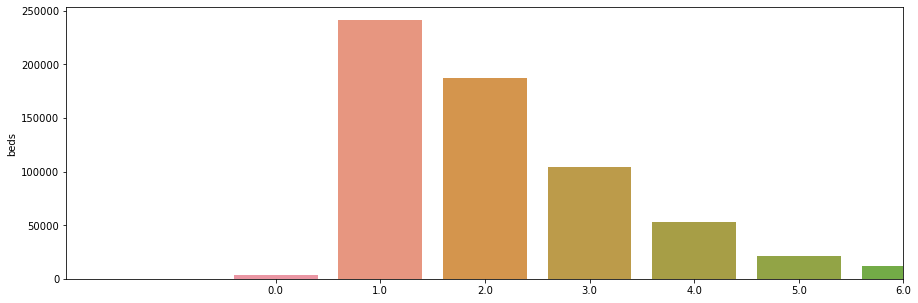

In [48]:
diagrama_caixa(base_airbnb['beds'])
grafico_barra(base_airbnb['beds'])

In [49]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'beds')
print('{} linhas removidas'.format(linhas_removidas))

5622 linhas removidas


### guests_included

(1.0, 1.0)


<AxesSubplot:ylabel='guests_included'>

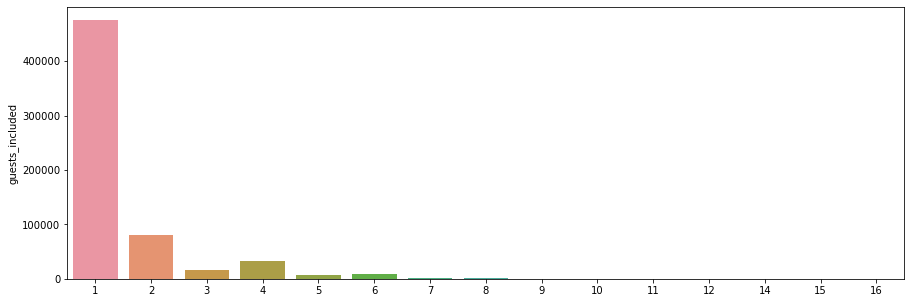

In [50]:
#diagrama_caixa(base_airbnb['guests_included'])
#grafico_barra(base_airbnb['guests_included'])
print(limites(base_airbnb['guests_included']))
plt.figure(figsize=(15, 5))
sns.barplot(x=base_airbnb['guests_included'].value_counts().index, y=base_airbnb['guests_included'].value_counts())

- Vamos excluir essa coluna da análise, pois o limite inferior e superior está dando igual a 1. Provavelmente porque as informações da coluna não estão preenchidas corretamente

In [51]:
#Exclunindo Coluna da tabela:
#O eixo 0 diz respeito às linhas e o 1 às colunas (axis=0, axis=1)
base_airbnb = base_airbnb.drop('guests_included', axis=1)
base_airbnb.shape

(622366, 22)

### minimum_nights   

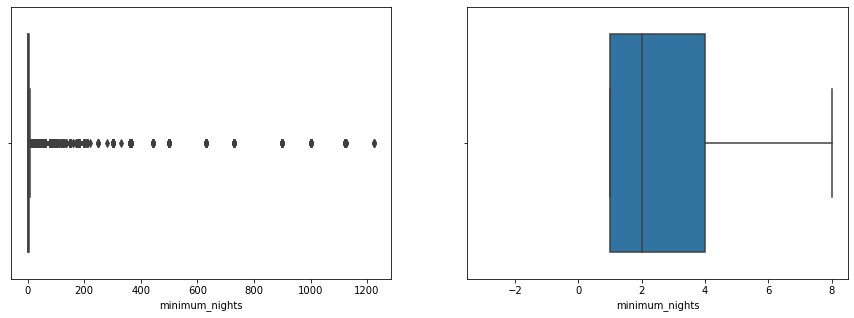

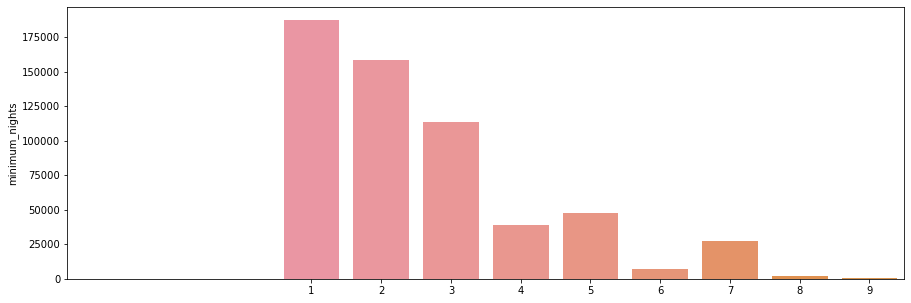

In [52]:
diagrama_caixa(base_airbnb['minimum_nights'])
grafico_barra(base_airbnb['minimum_nights'])

In [53]:
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'minimum_nights')
print('{} linhas removidas'.format(linhas_removidas))

40383 linhas removidas


### maximum_nights 

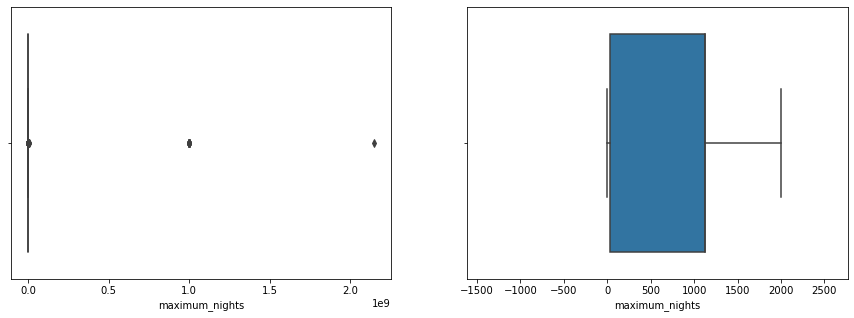

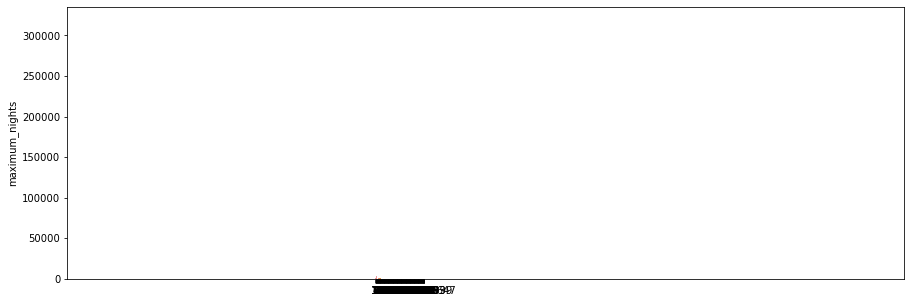

In [54]:
diagrama_caixa(base_airbnb['maximum_nights'])
grafico_barra(base_airbnb['maximum_nights'])

In [55]:
base_airbnb = base_airbnb.drop('maximum_nights', axis=1)
base_airbnb.shape

(581983, 21)

### number_of_reviews

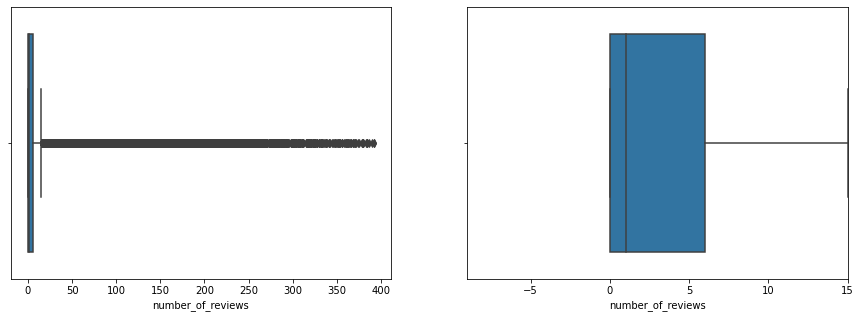

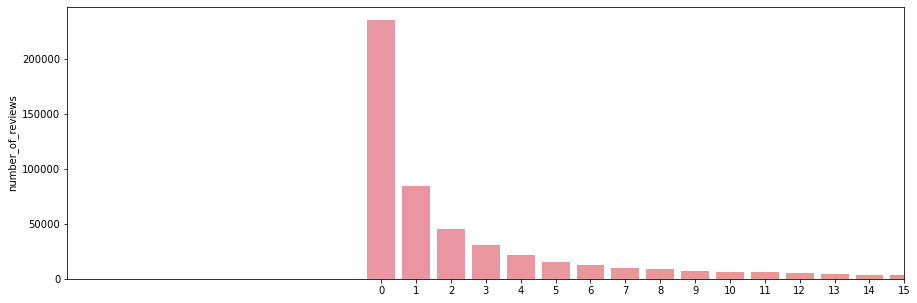

In [56]:
diagrama_caixa(base_airbnb['number_of_reviews'])
grafico_barra(base_airbnb['number_of_reviews'])

In [57]:
base_airbnb = base_airbnb.drop('number_of_reviews', axis=1)
base_airbnb.shape

(581983, 20)

### Tratamento de colunas de valores de texto

- property_type

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


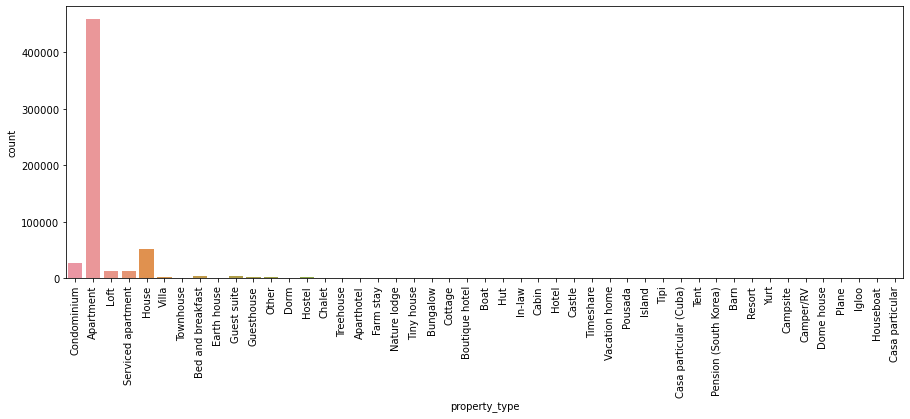

In [58]:
#print(base_airbnb['property_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

In [59]:
#tratando colunas para adicionar mais tipos de 'casa' no grupo others
lista_casas = base_airbnb['property_type'].value_counts()
lista_aux = []

for casa in lista_casas.index:
    if lista_casas[casa] < 2000:
        lista_aux.append(casa)
        
for casa in lista_aux:
    base_airbnb.loc[base_airbnb['property_type']==casa, 'property_type'] = 'Outros'

print(base_airbnb['property_type'].value_counts())

Apartment             458354
House                  51387
Condominium            26456
Serviced apartment     12671
Loft                   12352
Outros                  8850
Guest suite             3621
Bed and breakfast       3472
Hostel                  2665
Guesthouse              2155
Name: property_type, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


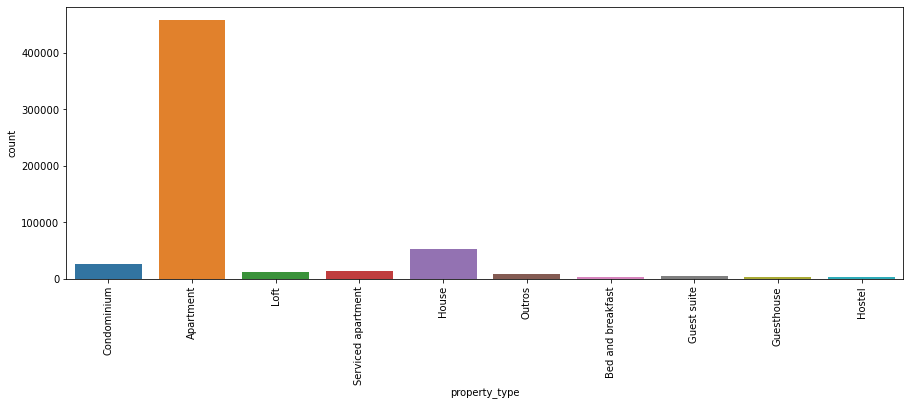

In [60]:
plt.figure(figsize=(15, 5))
grafico = sns.countplot('property_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- room_type

Entire home/apt    372443
Private room       196859
Shared room         11714
Hotel room            967
Name: room_type, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


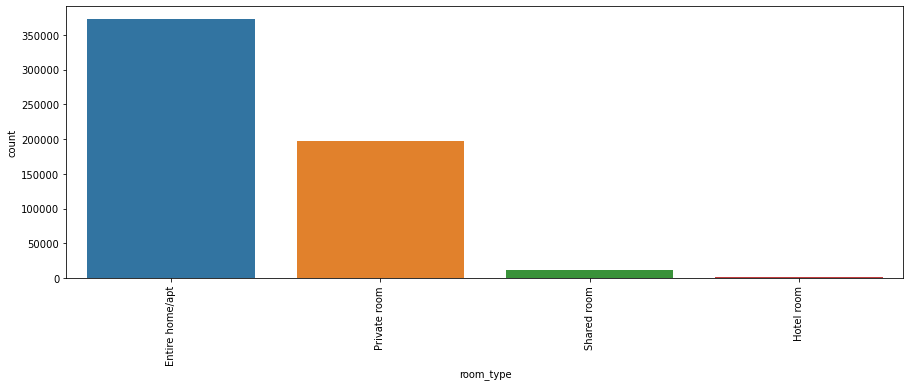

In [61]:
print(base_airbnb['room_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('room_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- bed_type

Real Bed         570643
Pull-out Sofa      8055
Futon              1634
Airbed             1155
Couch               496
Name: bed_type, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Real Bed    570643
Outras       11340
Name: bed_type, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


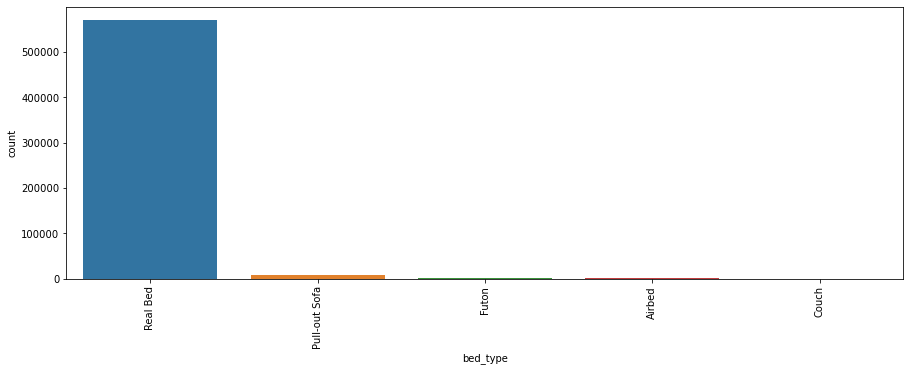

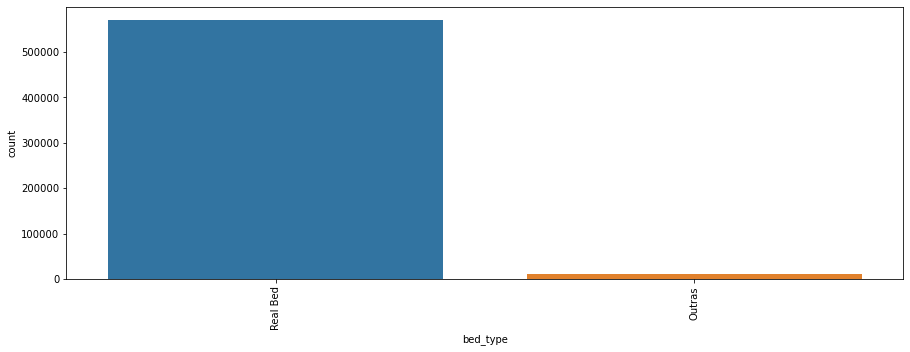

In [62]:
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#Agrupando outros tipos de cama como: (OUTRAS)

lista_outras = base_airbnb['bed_type'].value_counts()
lista_aux = []

for strict in lista_outras.index:
    if lista_outras[strict] < 10000:
        lista_aux.append(strict)
        
for strict in lista_aux:
    base_airbnb.loc[base_airbnb['bed_type']==strict, 'bed_type'] = 'Outras'
    
print(base_airbnb['bed_type'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('bed_type', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

- cancellation_policy

flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9696
super_strict_60                   135
super_strict_30                    32
Name: cancellation_policy, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


flexible                       258096
strict_14_with_grace_period    200743
moderate                       113281
strict                           9863
Name: cancellation_policy, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


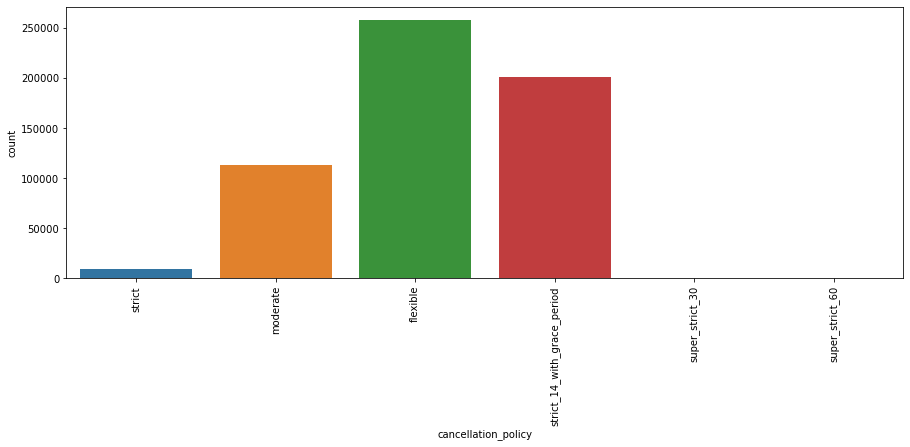

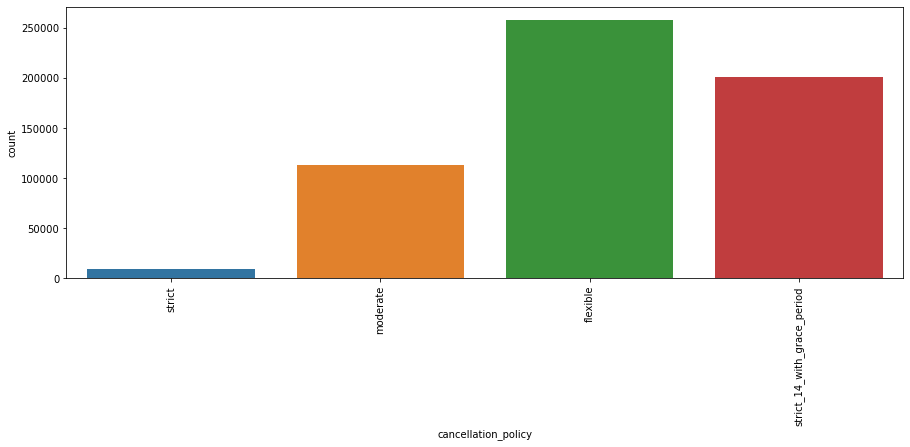

In [63]:
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

#Agrupando super_strict_60 e super_strict_30 em strict

lista_strict = base_airbnb['cancellation_policy'].value_counts()
lista_aux = []

for strict in lista_strict.index:
    if lista_strict[strict] < 10000:
        lista_aux.append(strict)
        
for strict in lista_aux:
    base_airbnb.loc[base_airbnb['cancellation_policy']==strict, 'cancellation_policy'] = 'strict'
    
print(base_airbnb['cancellation_policy'].value_counts())
plt.figure(figsize=(15, 5))
grafico = sns.countplot('cancellation_policy', data=base_airbnb)
grafico.tick_params(axis='x', rotation=90)

### amenities
- Analisando a coluna de amenities, podemos perceber que não existe um padrão nos itens listados dentro desta coluna. Por isso, decidimos ao invés de verificar o que existe dentro de cada linha, analisar apenas a quantidade de ítens que cada linha apresenta. Seguindo a seguinte lógica: Quanto mais amenities o imovél tiver, o host poderá cobrar um pouco mais caro por ele.

In [64]:
#Criando uma coluna com a quantidade de amenities 
base_airbnb['n_amenities'] = base_airbnb['amenities'].str.split(',').apply(len)

In [65]:
base_airbnb = base_airbnb.drop('amenities', axis=1)
base_airbnb.shape

(581983, 20)

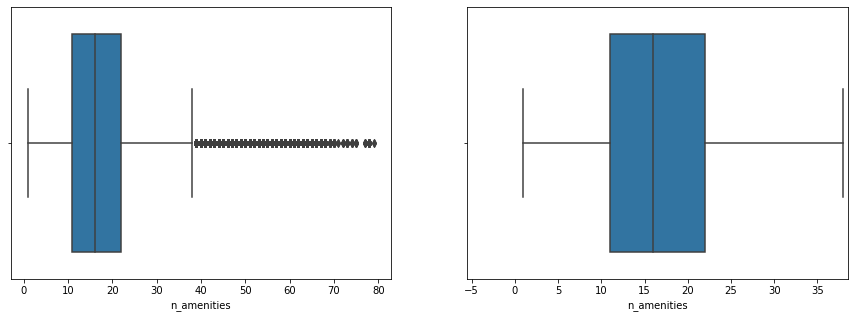

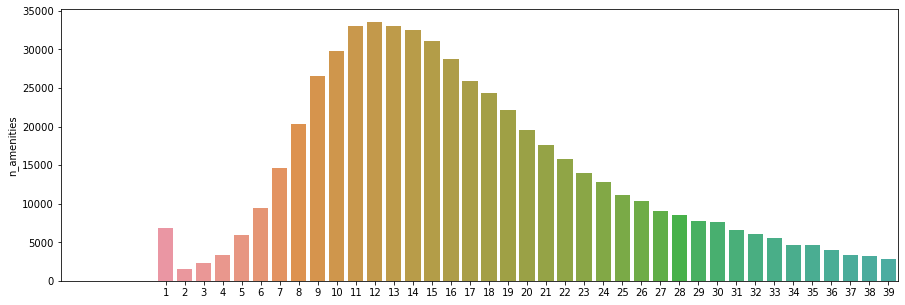

In [66]:
diagrama_caixa(base_airbnb['n_amenities'])
grafico_barra(base_airbnb['n_amenities'])

In [67]:
#exclunindo outliers
base_airbnb, linhas_removidas = excluir_outliers(base_airbnb, 'n_amenities')
print('{} linhas removidas'.format(linhas_removidas))

24343 linhas removidas


### Visualização de mapa das propriedades

In [68]:
#Criando um mapa dinamico para relacionar o preço com a localização do imóveis
amostra = base_airbnb.sample(50000)
centro_mapa = {'lat': amostra.latitude.mean(), 'lon': amostra.longitude.mean()}

mapa = px.density_mapbox(amostra, lat='latitude', lon='longitude', z='price', radius=2.5,
                        center=centro_mapa, zoom=10, mapbox_style='stamen-terrain')

mapa.show()

### Encoding

- Ajustaremos as features de True e False para facilitar o trabalho do modelo, substituiremos T por 1 e F por 0.
- Features de categoria (em que os valores da coluna são textos) vamos utilizar o metodo encoding de variáveis dummies.

In [69]:
#modificando 0 e 1
colunas_TF = ['host_is_superhost', 'instant_bookable', 'is_business_travel_ready']

base_airbnb_cod = base_airbnb.copy()

for coluna in colunas_TF:
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='t', coluna] = 1
    base_airbnb_cod.loc[base_airbnb_cod[coluna]=='f', coluna] = 0

In [70]:
colunas_categorias = ['property_type', 'room_type', 'bed_type', 'cancellation_policy']
base_airbnb_cod = pd.get_dummies(data=base_airbnb_cod, columns=colunas_categorias)
display(base_airbnb_cod)

host_is_superhost  host_listings_count   latitude  longitude  \
1                     1                  2.0 -22.965919 -43.178962   
3                     0                  3.0 -22.977117 -43.190454   
4                     1                  1.0 -22.983024 -43.214270   
5                     1                  1.0 -22.988165 -43.193588   
6                     1                  1.0 -22.981269 -43.190457   
...                 ...                  ...        ...        ...   
34323                 0                  1.0 -22.986030 -43.191660   
34324                 0                  0.0 -23.003180 -43.342840   
34325                 0                  0.0 -22.966640 -43.393450   
34327                 0                  0.0 -23.003400 -43.341820   
34328                 0                  5.0 -23.010560 -43.363350   

       accommodates  bathrooms  bedrooms  beds  price  extra_people  ...  \
1                 5        1.0       2.0   2.0  270.0          51.0  ...   
3                 3        1.0       1.0   2.0  161.0          45.0  ...   
4                 3        1.0       1.0   2.0  222.0          68.0  ...   
5                 3        1.5       1.0   2.0  308.0          86.0  ...   
6                 2        1.0       1.0   2.0  219.0          80.0  ...   
...             ...        ...       ...   ...    ...           ...  ...   
34323             4        2.0       2.0   3.0  250.0           0.0  ...   
34324             4        1.0       0.0   2.0  121.0          50.0  ...   
34325             4        2.0       2.0   3.0  799.0           0.0  ...   
34327             4        1.0       1.0   1.0  250.0           0.0  ...   
34328             2        0.0       1.0   1.0   92.0          80.0  ...   

       room_type_Entire home/apt room_type_Hotel room room_type_Private room  \
1                              1                    0                      0   
3                              1                    0                      0   
4                              1                    0                      0   
5                              1                    0                      0   
6                              1                    0                      0   
...                          ...                  ...                    ...   
34323                          1                    0                      0   
34324                          1                    0                      0   
34325                          1                    0                      0   
34327                          1                    0                      0   
34328                          0                    0                      1   

       room_type_Shared room  bed_type_Outras  bed_type_Real Bed  \
1                          0                0                  1   
3                          0                0                  1   
4                          0                0                  1   
5                          0                0                  1   
6                          0                0                  1   
...                      ...              ...                ...   
34323                      0                0                  1   
34324                      0                0                  1   
34325                      0                0                  1   
34327                      0                0                  1   
34328                      0                0                  1   

       cancellation_policy_flexible  cancellation_policy_moderate  \
1                                 0                             0   
3                                 0                             0   
4                                 0                             0   
5                                 0                             0   
6                                 0                             0   
...                             ...                         

### Modelo de Previsão

- Métricas de avaliação

In [71]:
def avaliar_modelo(nome_modelo, y_teste, previsao):
    r2 = r2_score(y_teste, previsao)#R²
    RSME = np.sqrt(mean_squared_error(y_teste, previsao))#Erro quadrático médio
    return f'Modelo: {nome_modelo}\nR²: {r2:.2%}\nRSME: {RSME:.2f}'

- Escolha dos modelos a serem testados
    1. RandomForest
    2. LinearRegression
    3. ExtraTree

In [72]:
modelo_rf = RandomForestRegressor()
modelo_lr = LinearRegression()
modelo_et = ExtraTreesRegressor()

modelos = {'RandomForest': modelo_rf,
           'LinearRegression': modelo_lr,
           'ExtraTree': modelo_et,
          }

y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

- Separar dados em trino e teste e treinar o modelo

In [73]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

for nome_modelo, modelo in modelos.items(): #o .items() retorna uma tupla com o nomedomodelo e a estancia do modelo
    #treinar
    modelo.fit(x_train, y_train)
    #testar
    previsao = modelo.predict(x_test)
    print(avaliar_modelo(nome_modelo, y_test, previsao))


Modelo: RandomForest
R²: 97.25%
RSME: 43.94
Modelo: LinearRegression
R²: 32.70%
RSME: 217.54
Modelo: ExtraTree
R²: 97.51%
RSME: 41.83


- Modelo Escolhido como Melhor Modelo: ExtraTreesRegressor

    Esse foi o modelo com maior valor de R² e ao mesmo tempo o menor valor de RSME. Como não tivemos uma grande diferença de velocidade de treino e de previsão desse modelo com o modelo de RandomForest (que teve resultados próximos de R² e RSME), vamos escolher o Modelo ExtraTrees.
    
    O modelo de regressão linear não obteve um resultado satisfatório, com valores de R² e RSME muito piores do que os outros 2 modelos.
    
- Resultados das Métricas de Avaliaçõ no Modelo Vencedor:<br>
Modelo ExtraTrees:<br>
R²: 97.51%<br>
RSME: 41.83

### Análise do Melhor Modelo

[0.01325064 0.03983471 0.1038856  0.10185327 0.07266392 0.07152155
 0.1194297  0.05272187 0.08512132 0.06594043 0.02224504 0.
 0.00471625 0.01127817 0.08848588 0.0128126  0.00130305 0.00519911
 0.00066947 0.00093849 0.00064079 0.00714888 0.00214762 0.00237502
 0.00222946 0.05929489 0.00030919 0.00437828 0.00185371 0.00263199
 0.00269802 0.01980739 0.01214864 0.00084739 0.00761768]


 Index(['host_is_superhost', 'host_listings_count', 'latitude', 'longitude',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'extra_people',
       'minimum_nights', 'instant_bookable', 'is_business_travel_ready', 'mes',
       'ano', 'n_amenities', 'property_type_Apartment',
       'property_type_Bed and breakfast', 'property_type_Condominium',
       'property_type_Guest suite', 'property_type_Guesthouse',
       'property_type_Hostel', 'property_type_House', 'property_type_Loft',
       'property_type_Outros', 'property_type_Serviced apartment',
       'room_type_Entire home/apt', 'room_type_Hote

0
bedrooms                                         0.119430
latitude                                         0.103886
longitude                                        0.101853
n_amenities                                      0.088486
extra_people                                     0.085121
accommodates                                     0.072664
bathrooms                                        0.071522
minimum_nights                                   0.065940
room_type_Entire home/apt                        0.059295
beds                                             0.052722
host_listings_count                              0.039835
instant_bookable                                 0.022245
cancellation_policy_flexible                     0.019807
host_is_superhost                                0.013251
property_type_Apartment                          0.012813
cancellation_policy_moderate                     0.012149
ano                                              0.011278
cancellation_policy_strict_14_with_grace_period  0.007618
property_type_House                              0.007149
property_type_Condominium                        0.005199
mes                                              0.004716
room_type_Private room                           0.004378
bed_type_Real Bed                                0.002698
bed_type_Outras                                  0.002632
property_type_Outros                             0.002375
property_type_Serviced apartment                 0.002229
property_type_Loft                               0.002148
room_type_Shared room                            0.001854
property_type_Bed and breakfast                  0.001303
property_type_Guesthouse                         0.000938
cancellation_policy_strict                       0.000847
property_type_Guest suite                        0.000669
property_type_Hostel                             0.000641
room_type_Hotel room                             0.000309
is_business_travel_ready                         0.000000

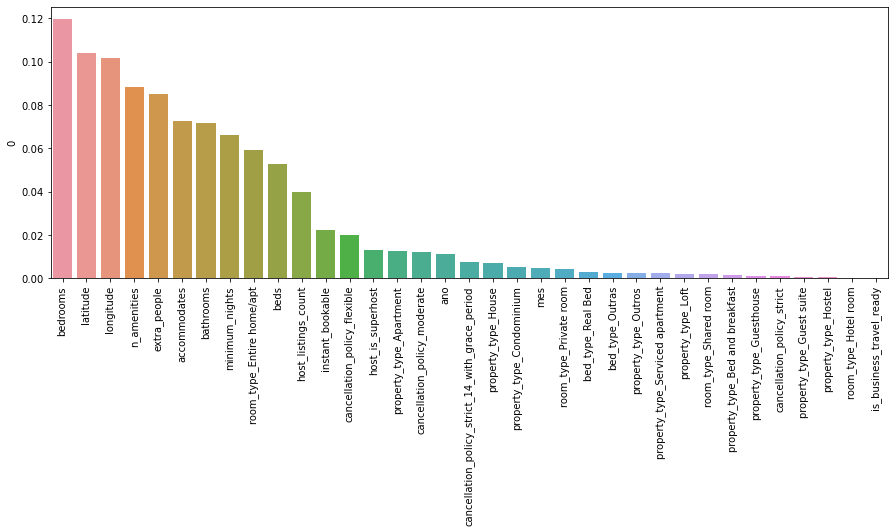

In [74]:
print(modelo_et.feature_importances_)
print('\n\n', x_test.columns)

importancia_features = pd.DataFrame(modelo_et.feature_importances_, x_test.columns)
importancia_features = importancia_features.sort_values(by=0, ascending=False)
display(importancia_features)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x = importancia_features.index, y = importancia_features[0])
ax.tick_params(axis='x', rotation=90)

### Ajustes e Melhorias no Melhor Modelo (ExtraTrees)

- De acordo com o gráfico, a importancia da coluna (is_business_travel_ready) é 0.0000, por esse motivo vamos excluir essa coluna do dataframe para tornar o modelo mais leve 

In [75]:
#Excluindo coluna do dataframe
base_airbnb_cod = base_airbnb_cod.drop('is_business_travel_ready', axis=1)

In [76]:
y = base_airbnb_cod['price']
x = base_airbnb_cod.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

#treinar
modelo_et.fit(x_train, y_train)
#testar
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo: ExtraTrees
R²: 97.51%
RSME: 41.83


In [77]:
base_teste = base_airbnb_cod.copy()  

for coluna in base_teste:
    if 'bed_type' in coluna:
        base_teste = base_teste.drop(coluna, axis=1)

y = base_teste['price']
x = base_teste.drop('price', axis=1)

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=10)

#treinar
modelo_et.fit(x_train, y_train)
#testar
previsao = modelo_et.predict(x_test)
print(avaliar_modelo('ExtraTrees', y_test, previsao))

Modelo: ExtraTrees
R²: 97.48%
RSME: 42.05


### Exportando a base de dados tratada para um arquivo csv

In [78]:
x['price'] = y
x.to_csv('modelo_final.csv')

In [79]:
import joblib
joblib.dump(modelo_et, 'modelo.joblib')

['modelo.joblib']